In [1]:
import numpy as np
import const
from fpath import *
from scipy.interpolate import interp1d
from math import pi, log10, sqrt, log, exp, sqrt, atan, cos, sin, acos, asin

In [2]:
# adjustable parameters
nH0 = 1                # [cm^-3] H number density
tmax = 300.     # [s], duration of the source
LUV = 3e47      # [erg/s]  # source luminosity

# fixed parameters
tmin = 0.
n0_over_nH = 1.45e-15    # dust number density over H number density
lam0 = 2.       # [um] critical wavelength for Qabs_lambda
thej = 4*pi/180     # [rad] jet opening angle
p = 2.2         # electron PL index => spectrum L_nu ~ nu^{(1-p)/2}
nuUVmax = 50/const.erg2eV/const.H_PLANCK   # maximum UV frequency 50 eV
LnuUVmax = (3-p)/2*LUV/nuUVmax   # Lnu at nuUVmax

In [3]:
amin, amax = 0.01, 0.3      # um, grain size limits
Na = 30
aarr = np.logspace(log10(amin), log10(amax), Na)
a_ratio = aarr[1]/aarr[0]

rmin, rmax = 0.4, 100.       # pc, radial layers
Nr = 150     # we need dr/r <~ thej to resolve the light curve of the echo
rarr = np.logspace(log10(rmin), log10(rmax), Nr)
r_ratio = rarr[1]/rarr[0]

# min and max source frequencies
numin, numax = 0.1/(const.erg2eV*const.H_PLANCK), 50/(const.erg2eV*const.H_PLANCK)
Nnu = 40
nuarr = np.logspace(log10(numin), log10(numax), Nnu)    # frequency bins
nu_ratio = nuarr[1]/nuarr[0]

# jet emission time [dust local frame]
Nt = 20     # this is the dimension we interpolate over
tarr = np.linspace(tmin, tmax, Nt, endpoint=False)
dt = tarr[1] - tarr[0]
tarr += dt/2.

Tarr = np.zeros((Nt, Nr, Na), dtype=float)   # to store the dust temperature
asubarr = np.zeros((Nt, Nr), dtype=float)    # to store sublimation radii
taudarr = np.zeros((Nnu, Nr), dtype=float)   # dust extinction optical depth at each nu

In [4]:
def func_Lnu(t, nu):     # source spectrum and light curve
    if t < tmax:
        return LnuUVmax*(nu/nuUVmax)**((1 - p)/2)  # spectrum L_nu ~ nu^{(1-p)/2}
    return 0.

In [5]:
def func_nH(r):      # gas density profile (r in pc)
    return nH0

In [6]:
def func_Qabs(nu, a):      # absorption efficiency for grain size a [um]
    lam = const.C_LIGHT/nu * 1e4    # wavelength in um
    return 1./(1 + (lam/lam0)**2 / a)

In [7]:
def func_T(qdot_h, aum):    # solve the heating and cooling balance for T
    y = qdot_h/(7.12576*aum**2)
    if y >= (31.5/aum)**2/12:
        return 3240/sqrt(aum)   # the grain should evaporate immediately
    xi = sqrt((31.5/aum)**2 - 12*y) + 31.5/aum
    T3 = sqrt((2*y*y/3/xi)**(1./3) + (xi*y/18)**(1./3))
    return 1000*T3

In [8]:
# compute cumulative number of H as a function of radius
Nr_fine = int(Nr*10)
rarr_fine = np.logspace(log10(rmin/10), log10(rmax), Nr_fine)
r_ratio_fine = rarr_fine[1]/rarr_fine[0]
NHarr_fine = np.zeros(Nr_fine, dtype=float)
NH = 0.     # total H number
for i in range(Nr_fine):
    r = rarr_fine[i]
    dr = r * (sqrt(r_ratio_fine) - 1/sqrt(r_ratio_fine))
    NH += 4*pi*r*r*dr*const.pc2cm**3 * func_nH(r)
    NHarr_fine[i] = NH
r_NH_intp = interp1d(rarr_fine, NHarr_fine, fill_value='extrapolate')

In [9]:
NHarr_fine

array([1.23330854e+50, 2.48608086e+50, 3.75862415e+50, ...,
       1.20208641e+62, 1.22105746e+62, 1.24032791e+62], shape=(1500,))

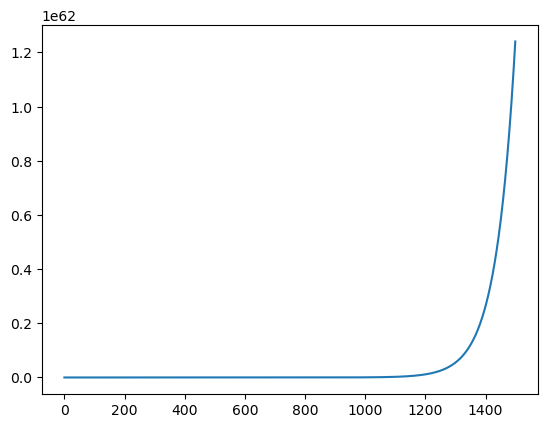

In [10]:
from matplotlib import pyplot as plt
plt.plot(NHarr_fine)

In [11]:
# compute cumulative number of ionizing photons as a function of time
Nt_fine = int(Nt*20)
tarr_fine = np.linspace(tmin, tmax, Nt_fine)
dt_fine = tarr_fine[1] - tarr_fine[0]
tarr_fine += dt_fine/2.
Nionarr_fine = np.zeros(Nt_fine, dtype=float)   # cumulative number of ionizing photons
Nnu_fine = int(Nnu*5)
nu_ion_min, nu_ion_max = 13.6/(const.erg2eV*const.H_PLANCK), 100/(const.erg2eV*const.H_PLANCK)
nuarr_fine = np.logspace(log10(nu_ion_min), log10(nu_ion_max), Nnu_fine)
nu_ratio_fine = nuarr_fine[1]/nuarr_fine[0]

Nion = 0.
for i in range(Nt_fine):
    t = tarr_fine[i]
    Lion = 0.
    for j in range(Nnu):
        nu = nuarr_fine[j]
        dnu = nu * (sqrt(nu_ratio_fine) - 1/sqrt(nu_ratio_fine))
        Lion += dnu * func_Lnu(t, nu)/(const.H_PLANCK*nu)
    Nion += Lion*dt_fine
    Nionarr_fine[i] = Nion
Nion_t_intp = interp1d(Nionarr_fine, tarr_fine, fill_value='extrapolate')

In [12]:
Nionarr_fine

array([8.79395522e+56, 1.75879104e+57, 2.63818656e+57, 3.51758209e+57,
       4.39697761e+57, 5.27637313e+57, 6.15576865e+57, 7.03516417e+57,
       7.91455969e+57, 8.79395522e+57, 9.67335074e+57, 1.05527463e+58,
       1.14321418e+58, 1.23115373e+58, 1.31909328e+58, 1.40703283e+58,
       1.49497239e+58, 1.58291194e+58, 1.67085149e+58, 1.75879104e+58,
       1.84673060e+58, 1.93467015e+58, 2.02260970e+58, 2.11054925e+58,
       2.19848880e+58, 2.28642836e+58, 2.37436791e+58, 2.46230746e+58,
       2.55024701e+58, 2.63818656e+58, 2.72612612e+58, 2.81406567e+58,
       2.90200522e+58, 2.98994477e+58, 3.07788433e+58, 3.16582388e+58,
       3.25376343e+58, 3.34170298e+58, 3.42964253e+58, 3.51758209e+58,
       3.60552164e+58, 3.69346119e+58, 3.78140074e+58, 3.86934029e+58,
       3.95727985e+58, 4.04521940e+58, 4.13315895e+58, 4.22109850e+58,
       4.30903806e+58, 4.39697761e+58, 4.48491716e+58, 4.57285671e+58,
       4.66079626e+58, 4.74873582e+58, 4.83667537e+58, 4.92461492e+58,
      

In [13]:
# calculate dust temperature at a given time
def calculate_all_T(t, i_t, rion, Tarr, asubarr, taudarr):
    for j in range(Nr):
        r = rarr[j]
        asub = amin
        for k in range(Na):
            a = aarr[k]
            # calculate heating rate divided by pi*a^2
            qdot_h_over_pia2 = 0.
            for m in range(Nnu):
                nu = nuarr[m]
                dnu = nu * (sqrt(nu_ratio) - 1./sqrt(nu_ratio))
                if r < rion and nu > nu_ion_min:
                    break   # no photons above 13.6 eV ar r > rion
                qdot_h_over_pia2 += dnu * func_Lnu(t, nu) * exp(-taudarr[m, j])\
                                    /(4*pi*r*r*const.pc2cm**2) * func_Qabs(nu, a)
            qdot_h = qdot_h_over_pia2 * pi * a**2 * 1e-8    # heating rate [cgs]
            T = func_T(qdot_h, a)
            Tsub = 2.33e3 * (1 - 0.033*log(t/100./a))
            if T > Tsub:    # grains in this size bin have already evaporated
                asub = min(max(asub, a), amax)
                Tarr[i_t, j, k] = 0.   # no emission from this size bin
            else:   # grains survive
                Tarr[i_t, j, k] = T
        if i_t == 0:
            asubarr[i_t, j] = asub
        else:   # make sure asub does not decrease with time
            asubarr[i_t, j] = max(asub, asubarr[i_t-1, j])
    return

In [14]:
def calculate_taudarr(i_t, asubarr, taudarr):
    for m in range(Nnu):
        nu = nuarr[m]
        lam = const.C_LIGHT/nu*1e4   # in um
        xmax = amax * (lam0/lam)**2
        tau_pre_factor = 2*sqrt(2)*pi*1e-8*n0_over_nH*lam0/lam
        taud = 0.
        for j in range(Nr):
            r = rarr[j]
            dr = r * (sqrt(r_ratio) - 1./sqrt(r_ratio))
            xsub = asubarr[i_t, j] * (lam0/lam)**2
            taud += tau_pre_factor * dr * const.pc2cm * func_nH(r) \
                    * (atan(sqrt(0.5*xmax)) - atan(sqrt(0.5*xsub)))
            taudarr[m, j] = taud
    return

In [22]:
i = 19
t = tarr[i]
Nion = Nion_t_intp(t)
rion = r_NH_intp(Nion)  # ionization radius
taudarr.fill(0)    # first iteration, no dust extinction
calculate_all_T(t, i, rion, Tarr, asubarr, taudarr)
Tarr[0,:,:]

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [797.52060144, 784.45267672, 771.5143842 , ..., 497.33192489,
        488.40403263, 479.62825706],
       [787.72419595, 774.81629005, 762.03639874, ..., 491.19340658,
        482.37299632, 473.70270455],
       [778.04826542, 765.2984287 , 752.67500976, ..., 485.13144951,
        476.41727854, 467.85125708]], shape=(150, 30))

In [15]:
tol = 0.01  # tolerance for asubarr
for i in range(Nt):
    t = tarr[i]
    Nion = Nion_t_intp(t)
    rion = r_NH_intp(Nion)  # ionization radius
    taudarr.fill(0)    # first iteration, no dust extinction
    calculate_all_T(t, i, rion, Tarr, asubarr, taudarr)
    frac_diff = 1.  # convergence criterion
    n_iter = 0.     # number of iterations
    while frac_diff > tol:
        n_iter += 1
        asubarr_old = np.copy(asubarr[i])
        # we go back to calculate dust extinction optical depth
        calculate_taudarr(i, asubarr, taudarr)
        # then calculate the whole temperature again
        calculate_all_T(t, i, rion, Tarr, asubarr, taudarr)
        frac_diff = 0.
        for j in range(Nr):
            frac_diff = max(frac_diff, abs(asubarr_old[j]/asubarr[i, j] - 1))
    print('t=%.1f' % t, '%d iterations' % n_iter)

t=7.5 1 iterations
t=22.5 1 iterations
t=37.5 1 iterations
t=52.5 1 iterations
t=67.5 2 iterations
t=82.5 2 iterations
t=97.5 2 iterations
t=112.5 2 iterations
t=127.5 2 iterations
t=142.5 2 iterations
t=157.5 2 iterations
t=172.5 2 iterations
t=187.5 1 iterations
t=202.5 1 iterations
t=217.5 2 iterations
t=232.5 1 iterations
t=247.5 2 iterations
t=262.5 2 iterations
t=277.5 2 iterations
t=292.5 1 iterations


In [17]:
Tarr

array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [750.14517609, 738.0740899 , 726.12127288, ..., 471.79548149,
         463.45593786, 455.25325607],
        [739.18766276, 727.30165531, 715.53202866, ..., 465.04828576,
         456.83123205, 448.74866705],
        [728.32673486, 716.62440771, 705.03658862, ..., 458.36598068,
         450.2705019 , 442.30715901]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,


In [18]:
asubarr

array([[0.3 , 0.3 , 0.3 , ..., 0.01, 0.01, 0.01],
       [0.3 , 0.3 , 0.3 , ..., 0.01, 0.01, 0.01],
       [0.3 , 0.3 , 0.3 , ..., 0.01, 0.01, 0.01],
       ...,
       [0.3 , 0.3 , 0.3 , ..., 0.01, 0.01, 0.01],
       [0.3 , 0.3 , 0.3 , ..., 0.01, 0.01, 0.01],
       [0.3 , 0.3 , 0.3 , ..., 0.01, 0.01, 0.01]], shape=(20, 150))

In [ ]:
# write the results into files: Tarr, asubarr
savelist = ['Td', 'asub']
for i_file in range(len(savelist)):
    fname = 'nH%.1e_' % nH0 + savelist[i_file]
    with open(savedir+fname + '.txt', 'w') as f:
        if savelist[i_file] == 'Td':
            f.write('tmin\ttmax\tNt\t%.8e\t%.8e\t%d\tlinear' % (tmin, tmax, Nt))
            f.write('\nrmin\trmax\tNr\t%.8e\t%.8e\t%d\tlog' % (rmin, rmax, Nr))
            f.write('\namin\tamax\tNa\t%.8e\t%.8e\t%d\tlog' % (amin, amax, Na))
            f.write('\n')
            for i in range(Nt):
                t = tarr[i]
                f.write('\ni=%d, t=%.8e' % (i, t))
                for j in range(Nr):
                    f.write('\n')
                    for k in range(Na):
                        if k == 0:
                            f.write('%.8e' % Tarr[i, j, k])
                        else:
                            f.write('\t%.8e' % Tarr[i, j, k])
        elif savelist[i_file] == 'asub':
            f.write('tmin\ttmax\tNt\t%.8e\t%.8e\t%d\tlog' % (tmin, tmax, Nt))
            f.write('\nrmin\trmax\tNr\t%.8e\t%.8e\t%d\tlog' % (rmin, rmax, Nr))
            f.write('\n')
            for i in range(Nt):
                f.write('\n')
                for j in range(Nr):
                    if j == 0:
                        f.write('%.8e' % asubarr[i, j])
                    else:
                        f.write('\t%.8e' % asubarr[i, j])